### Installations

In [1]:
#!pip install lxml
#!pip install wget
#!pip install gpxpy

### Imports

In [2]:
# import requests
import re
from bs4 import BeautifulSoup 
import pandas as pd
import lxml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

import requests
#import wget
import glob
import datetime as dt
import time

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gpxpy 
import gpxpy.gpx 
import glob

# Still to do:
- Add key words: Webscraping from a static page, Data Cleaning, plots, GPX coordinates, KML coordinates (add both? describe the differences?), spatial data, tableau, visualization, seaboarn, matplotlib

- DONE with functions: import csv file instead of rescrapping (hash out the rest)

- DONE: change difficulty to '0 - No rating', '1 - Easy' etc
- DONE for corr matrix: remove '0 - No rating' for some plots
- DONE: easy = green etc
- DONE: nicer look of plots?

- DONE: create function for gpx part
- DONE: simplify gpx code
- WIP - blocked: run gpx code for all 257 codes (check if not blocked)
- DONE Taken out as not needed: check why datetime code does not always work

- DONE: Check comment with Google earth and "KML" file

# 1  Data scraping

Prepare to scrape the Bergfex.com website in order to create Pandas dataframes that contain important information about each trail. This code uses BeautifulSoup to parse the html tags into json, which is easier to work with. A for-loop iterates over each html tag and adds the corresponding information into empty lists. 

### 1.1 Scrape all the information (basic and more complicated)

In [3]:
title = []  # Title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # Sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time_list = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)
total_title = [] # will help extracting the ID of the tour

# all ratings are stored together so we will need this along the way:
rating = []  # list to store technique and fitness rating info

In [4]:
# looping over the x first pages of Bergfex
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 2  # number of pages we want to scrape through

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])
        total_title.append(tour_title) 
        # this gets the full tour-title information including the ID, will need to be processed further later on
        
        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time_list.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2


In [5]:
tours

[<div class="touren-detail">
 <a class="h2" href="/sommer/bern-region/touren/mountainbike/834956,berschel-tour/" title="Berschel Tour">Berschel Tour</a>
 <div>
 <span class="tour-difficulty tour-difficulty-3">
 difficult
 </span>
 <span class="tour-type">
 Mountainbike
 </span>
 </div>
 <div class="tour-stats-photos-container">
 <div class="tour-stats-container">
 <div class="tour-stats-left">
 <div class="tour-stats tour-stats-big">
 <div class="tour-stats-icon tour-stats-icon-length"></div>
 10.84<span class="tour-stats-unit">km</span>
 </div>
 <div class="tour-stats">
 <div class="tour-stats-icon tour-stats-icon-time"></div>
 <strong>01:40</strong><span class="tour-stats-unit">h</span>
 </div>
 </div>
 <div class="tour-stats-right">
 <div class="tour-stats tour-stats-big">
 <div class="tour-stats-icon tour-stats-icon-up"></div>
 488<span class="tour-stats-unit">hm</span>
 </div>
 <div class="tour-stats">
 <div class="tour-stats-icon tour-stats-icon-updown"></div>
 1,154 - 1,601<span

In [6]:
soup

<!DOCTYPE html>

<html>
<head>
<title>BERGFEX-  Swiss plateau - Hiking &amp; Mountain biking</title>
<script src="https://cdn.stroeerdigitalgroup.de/metatag/live/SDG_ConsentOnly/metaTag.min.js" type="text/javascript"></script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="en" http-equiv="Content-Language"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<meta content="en" name="language"/>
<meta content="width=device-width, viewport-fit=cover" name="viewport"/>
<script type="application/ld+json">
{
"@context": "https://schema.org",
"@type": "Organization",
"url": "https://www.bergfex.com",
"logo": "https://www.bergfex.com/images/logo.png"
}
</script>
<meta content="" property="og:title"/>
<meta content="https://vcdn.bergfex.at/images/resized/d8/a65a94fd11f0d3d8_2931d3a04a0e346a.jpg" property="og:image"/>
<meta content="image/jpg" property="og:image:type"/>
<meta content="1200" property="og:image:width"/>
<meta content="627" property="og:ima

In [7]:
print("number of tours collected:", len(title))

number of tours collected: 40


### 1.2 Extracting embedded HTML tags: <a href="" 
Each trail name and ID was used in Bergfex's URL. Using the trail ID in the dataframe will provide a unique ID to use later in the analysis. However, those two data points are embedded deeper in the html code. The below codes shows how to extract the datapoints into a dataframe.

In [8]:
# Extracting the ID via the URL
links_title = []

for i in total_title:
    i = str(i)
    i = i.strip('[]')
    links_title.append(i)

In order to make the trail ID usable it needs to be cleaned up and converted into a string

In [9]:
# Extracting ID
id_df3 = pd.DataFrame(links_title)
id_df2 = id_df3[0].str.split(' ',expand = True)
id_df1 = id_df2[2].str.split(',',expand = True)
id_df = id_df1[0].str.split('/',expand = True)

In [10]:
# from this format:
pd.options.display.max_colwidth = 100
id_df3.head()

,0
0,"<a class=""h2"" href=""/sommer/bern-region/touren/mountainbike/698705,ueschenen-biketour/"" title=""Ü..."
1,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/509375,meraengge-cher-im-kemmribodenbad..."
2,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/92457,auf-den-gurten-den-berner-hausber..."
3,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/114222,grenzerfahrung-durch-die-comb-de..."
4,"<a class=""h2"" href=""/sommer/bern-region/touren/laufen/891249,bluemlisalp-lauf--stecke/"" title=""B..."


In [11]:
# to this format:
id_df.head()

,0,1,2,3,4,5
0,"href=""",sommer,bern-region,touren,mountainbike,698705
1,"href=""",sommer,bern-region,touren,wanderung,509375
2,"href=""",sommer,bern-region,touren,wanderung,92457
3,"href=""",sommer,bern-region,touren,wanderung,114222
4,"href=""",sommer,bern-region,touren,laufen,891249


### 1.3 Extracting embedded HTML tags: <Div class=""
The HTML tags for the fitness and technique ratings were embedded within Div class tags; they are extracted using a for-loop and then stripped of unecessary characeters. 
- Convert the tour rating tag into a string
- Strip away unecessary characters 
- Split into lists which look like rating_list [Technique, Fitness]
- Finally, convert into seperate lists for Technique and Fitness

In [12]:
rating[0] # View the emmbedded DIV tag

[<div class="tour-rating">
 <div class="tour-rating-label">Technique</div>
 <div class="rating-circles rating-max6"><div class="rating-"></div></div>
 </div>,
 <div class="tour-rating">
 <div class="tour-rating-label">Fitness</div>
 <div class="rating-circles rating-max6"><div class="rating-4"></div></div>
 </div>]

In [13]:
# Replace unwanted information
tour_rating_str = str(rating)
rating_all_short = tour_rating_str.replace(
'<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
).replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')
rating_list = rating_even_shorter.split(", ")

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # add first item in technique
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other appended to fitness list

In [14]:
## Let's look at the result

#rating_all_short
#rating_even_shorter
rating_list

['rating-',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-',
 'rating-0',
 'rating-4',
 'rating-0',
 'rating-3',
 'rating-3',
 'rating-2',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-4',
 'rating-4',
 'rating-3',
 'rating-4',
 'rating-5',
 'rating-5',
 'rating-2',
 'rating-3',
 'rating-',
 'rating-4',
 'rating-',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-4',
 'rating-5',
 'rating-5',
 'rating-3',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-4',
 'rating-6',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-3',
 'rating-1',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-',
 'rating-0',
 'rating-',
 'rating-0',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-4',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-4',
 'rating-4',
 'rating-6',
 'rating-',
 'rating-0',
 'rating-1',
 'rating-1',
 'rating-4',
 'rating-6',
 'rating-1',
 'rating-3',
 'rating-3',
 'rating-3',
 'rating-2',
 'rating-3

### 1.4  Create dataframe for extracted elements

This dataframe is not in the final stage yet as there are still extra brackets, the minimum and maximum elevation are still in one column, and units must be stripped away

In [15]:
activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
activities_df_unclean.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Üschenen Biketour],[medium],[Mountainbike],23.88km,02:55h,835hm,"1,171 - 1,975m",rating-,rating-4,698705
1,[Merängge-Cher im Kemmribodenbad],[easy],[Hiking],6.97km,02:10h,330hm,"975 - 1,184m",rating-2,rating-2,509375
2,"[Auf den Gurten, den Berner Hausberg]",[],[Hiking],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
3,[Grenzerfahrung durch die Comb de Biaufonds],[],[Hiking],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222
4,[Blümlisalp-Lauf - Stecke],[medium],[Running],15.94km,05:05h,886hm,"706 - 1,409m",rating-4,rating-0,891249


### 1.5 Write CSV file of scrapped and uncleaned DF

In [16]:
activities_df_unclean.to_csv("../data/unclean_activities.csv", index=False)
activities_df_unclean.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Üschenen Biketour],[medium],[Mountainbike],23.88km,02:55h,835hm,"1,171 - 1,975m",rating-,rating-4,698705
1,[Merängge-Cher im Kemmribodenbad],[easy],[Hiking],6.97km,02:10h,330hm,"975 - 1,184m",rating-2,rating-2,509375
2,"[Auf den Gurten, den Berner Hausberg]",[],[Hiking],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
3,[Grenzerfahrung durch die Comb de Biaufonds],[],[Hiking],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222
4,[Blümlisalp-Lauf - Stecke],[medium],[Running],15.94km,05:05h,886hm,"706 - 1,409m",rating-4,rating-0,891249


### Scrape Regions (to be deleted)

In [17]:
regions = []
base_link_region = 'https://www.bergfex.com/sommer/berneroberland/'
page_region = requests.get(base_link_region, timeout=5)
soup_region = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
region = soup.findAll('div', {'class': 'box-content greid cols2'})  # checks for the separate tours on the page
region2 = soup.findAll('a', {'href': '*/sommer/*'})
region3 = soup.findAll('li', {'class': 'has-children collapsed'})

In [18]:
soup_region

<!DOCTYPE html>

<html>
<head>
<title>BERGFEX-  Swiss plateau - Hiking &amp; Mountain biking</title>
<script src="https://cdn.stroeerdigitalgroup.de/metatag/live/SDG_ConsentOnly/metaTag.min.js" type="text/javascript"></script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="en" http-equiv="Content-Language"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<meta content="en" name="language"/>
<meta content="width=device-width, viewport-fit=cover" name="viewport"/>
<script type="application/ld+json">
{
"@context": "https://schema.org",
"@type": "Organization",
"url": "https://www.bergfex.com",
"logo": "https://www.bergfex.com/images/logo.png"
}
</script>
<meta content="" property="og:title"/>
<meta content="https://vcdn.bergfex.at/images/resized/d8/a65a94fd11f0d3d8_2931d3a04a0e346a.jpg" property="og:image"/>
<meta content="image/jpg" property="og:image:type"/>
<meta content="1200" property="og:image:width"/>
<meta content="627" property="og:ima

In [19]:
region3

[<li class="has-children collapsed">
 <a>Winter</a>
 <ul>
 <li class="has-children collapsed">
 <h2>Topics</h2>
 <ul>
 <li><a href="/schweiz/">Ski resorts</a></li>
 <li>
 <a href="/schweiz/snow-parks/">Snow parks</a></li>
 <li>
 <a href="/schweiz/langlaufen/">Cross-country skiing</a></li>
 <li><a href="/schweiz/unterkuenfte/">Accommodation</a></li>
 </ul>
 </li>
 <li class="has-children collapsed"> <!-- define max height for section, overflow scroll -->
 <h2>Countries</h2>
 <ul>
 <li>
 <a href="/oesterreich/">Austria</a>
 </li>
 <li class="selected">
 <a href="/schweiz/">Switzerland</a>
 </li>
 <li>
 <a href="/deutschland/">Germany</a>
 </li>
 <li>
 <a href="/italien/">Italy</a>
 </li>
 <li>
 <a href="/slovenia/">Slovenia</a>
 </li>
 <li>
 <a href="/frankreich/">France</a>
 </li>
 <li>
 <a href="/nederland/">Netherlands</a>
 </li>
 <li>
 <a href="/belgie/">Belgium</a>
 </li>
 <li>
 <a href="/polska/">Poland</a>
 </li>
 <li>
 <a href="/czechia/">Czechia</a>
 </li>
 <li>
 <a href="/slova

In [20]:
region_copy = region3.copy()

In [21]:
region_copy

[<li class="has-children collapsed">
 <a>Winter</a>
 <ul>
 <li class="has-children collapsed">
 <h2>Topics</h2>
 <ul>
 <li><a href="/schweiz/">Ski resorts</a></li>
 <li>
 <a href="/schweiz/snow-parks/">Snow parks</a></li>
 <li>
 <a href="/schweiz/langlaufen/">Cross-country skiing</a></li>
 <li><a href="/schweiz/unterkuenfte/">Accommodation</a></li>
 </ul>
 </li>
 <li class="has-children collapsed"> <!-- define max height for section, overflow scroll -->
 <h2>Countries</h2>
 <ul>
 <li>
 <a href="/oesterreich/">Austria</a>
 </li>
 <li class="selected">
 <a href="/schweiz/">Switzerland</a>
 </li>
 <li>
 <a href="/deutschland/">Germany</a>
 </li>
 <li>
 <a href="/italien/">Italy</a>
 </li>
 <li>
 <a href="/slovenia/">Slovenia</a>
 </li>
 <li>
 <a href="/frankreich/">France</a>
 </li>
 <li>
 <a href="/nederland/">Netherlands</a>
 </li>
 <li>
 <a href="/belgie/">Belgium</a>
 </li>
 <li>
 <a href="/polska/">Poland</a>
 </li>
 <li>
 <a href="/czechia/">Czechia</a>
 </li>
 <li>
 <a href="/slova

In [22]:
soup_region

<!DOCTYPE html>

<html>
<head>
<title>BERGFEX-  Swiss plateau - Hiking &amp; Mountain biking</title>
<script src="https://cdn.stroeerdigitalgroup.de/metatag/live/SDG_ConsentOnly/metaTag.min.js" type="text/javascript"></script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="en" http-equiv="Content-Language"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<meta content="en" name="language"/>
<meta content="width=device-width, viewport-fit=cover" name="viewport"/>
<script type="application/ld+json">
{
"@context": "https://schema.org",
"@type": "Organization",
"url": "https://www.bergfex.com",
"logo": "https://www.bergfex.com/images/logo.png"
}
</script>
<meta content="" property="og:title"/>
<meta content="https://vcdn.bergfex.at/images/resized/d8/a65a94fd11f0d3d8_2931d3a04a0e346a.jpg" property="og:image"/>
<meta content="image/jpg" property="og:image:type"/>
<meta content="1200" property="og:image:width"/>
<meta content="627" property="og:ima

###  1.6 Combine all in scraping function

To be able to repeat the same steps for a different region (for example "Wallis"), we put the scraping code into a function. Here we can choose the region, how many pages we want to scrape and whether we want to save the file as CSV.

In [23]:
def scraping_region(region, n_pages):
    title = []  # Title of the tour
    difficulty = []  # difficulty (easy, medium, hard)
    sport = []  # Sport type (hiking, sledging, snowshoe...)
    length = []  # length in km
    time_list = []  # tour time in hours:minutes
    climb = []  # positive elevation climb in m
    minmax = []  # minimum and maximum altitude of the tour in m
    total_title = [] # will help extracting the ID of the tour
    # all ratings are stored together so we will need this along the way:
    rating = []  # list to store technique and fitness rating info
    
    # looping over the x first pages of Bergfex
    # each separate tour on the page is framed by a div tag with 'touren-details'
    page_number = n_pages  # number of pages we want to scap through

    for p in range(1, (page_number+1)):
        base_link = f'https://www.bergfex.com/sommer/{region}/touren/?isAjax=1&page='
        link = base_link+str(p)  # going over p pages with numbers appended to the base link
        page = requests.get(link, timeout=5)
        print("scraped page", p)
        soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
        tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

    # For each page, we loop over each tour and fill our lists with info     
        for i in range(0,len(tours)):
            tour_1 = tours[i] # tour iterating over the 20 tours of the page

            tour_title = tour_1.findAll('a' ) # this gets the title out
            title.append([info.get_text().strip() for info in tour_title])
            total_title.append(tour_title) 
            # this gets the full tour-title information including the ID, processed further later on

            tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
            difficulty.append([info.get_text().strip() for info in tour_diff])

            tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
            sport.append([info.get_text().strip() for info in tour_type])

            tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
            stat_text = [info.get_text().strip() for info in tour_stats]
            length.append(stat_text[0])
            time_list.append(stat_text[1])
            climb.append(stat_text[2])
            minmax.append(stat_text[3])

            tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
            rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.
    print("number of tours collected:", len(title))
    return (title, difficulty, sport, length, time_list, climb, minmax, total_title, rating)

In [24]:
def extracting_id(total_title):
    links_title = []
    for i in total_title:
        i = str(i)
        i = i.strip('[]')
        links_title.append(i)
    # Extracting ID
    id_df3 = pd.DataFrame(links_title)
    id_df2 = id_df3[0].str.split(' ',expand = True)
    id_df1 = id_df2[2].str.split(',',expand = True)
    id_df = id_df1[0].str.split('/',expand = True)
    
    return id_df

In [25]:
def extracting_rating(rating):
    technique = []  # technique difficulty ratings (out of 6)
    fitness = []  # fitness difficulty ratings (out of 6)
    # Replace unwanted information
    tour_rating_str = str(rating)
    rating_all_short = tour_rating_str.replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
    ).replace(
        '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
    rating_even_shorter = rating_all_short.replace('[','').replace(']','')
    rating_list = rating_even_shorter.split(", ")

    for i in range(0,(len(rating_list))):
        if i == 0:
            technique.append(rating_list[i]) # add first item in technique
        elif i % 2 == 0:
            technique.append(rating_list[i]) # then every second item as well
        else:
            fitness.append(rating_list[i]) # the other appended to fitness list
    return technique, fitness

In [26]:
def create_scraped_df(region, n_pages, save_as_csv = True):
    title, difficulty, sport, length, time_list, climb, minmax, total_title, rating = scraping_region(
        region, n_pages)
    id_df = extracting_id(total_title)
    technique, fitness = extracting_rating(rating)
    activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
    activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
    
    if save_as_csv == True:
        activities_df_unclean.to_csv(f"../data/unclean_activities_{region}.csv", index=False)
        
    return activities_df_unclean

Let's test it with different regions

In [27]:
region2 = "wallis"
n_pages2 = 20
#create_scraped_df(region2, n_pages2, save_as_csv = True)
#create_scraped_df('bern-region', n_pages2, save_as_csv = True)

# 2  Data Cleaning

As mentioned above, the dataframe still needs to be cleaned up. 

### 2.0 Read in the "uncleaned" DF

In [28]:
activities_df_raw = pd.read_csv(f"../data/unclean_activities.csv")
activities_df = activities_df_raw.copy()
activities_df.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,['Üschenen Biketour'],['medium'],['Mountainbike'],23.88km,02:55h,835hm,"1,171 - 1,975m",rating-,rating-4,698705
1,['Merängge-Cher im Kemmribodenbad'],['easy'],['Hiking'],6.97km,02:10h,330hm,"975 - 1,184m",rating-2,rating-2,509375
2,"['Auf den Gurten, den Berner Hausberg']",[],['Hiking'],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
3,['Grenzerfahrung durch die Comb de Biaufonds'],[],['Hiking'],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222
4,['Blümlisalp-Lauf - Stecke'],['medium'],['Running'],15.94km,05:05h,886hm,"706 - 1,409m",rating-4,rating-0,891249


### 2.1 Check for duplicates and remove them

In [29]:
# check if there are duplicates
dups = activities_df.duplicated(subset=['ID'])
dups

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
25    False
26     True
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool

In [30]:
# Which trails are duplicates?
pd.concat(g for _, g in activities_df.groupby('ID') if len(g) > 1)

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
2,"['Auf den Gurten, den Berner Hausberg']",[],['Hiking'],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
24,"['Auf den Gurten, den Berner Hausberg']",[],['Hiking'],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
3,['Grenzerfahrung durch die Comb de Biaufonds'],[],['Hiking'],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222
26,['Grenzerfahrung durch die Comb de Biaufonds'],[],['Hiking'],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222


In [31]:
# Remove duplicates
activities_df.drop_duplicates(subset ="ID", inplace = True)
activities_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,['Üschenen Biketour'],['medium'],['Mountainbike'],23.88km,02:55h,835hm,"1,171 - 1,975m",rating-,rating-4,698705
1,['Merängge-Cher im Kemmribodenbad'],['easy'],['Hiking'],6.97km,02:10h,330hm,"975 - 1,184m",rating-2,rating-2,509375
2,"['Auf den Gurten, den Berner Hausberg']",[],['Hiking'],4.22km,01:10h,128hm,748 - 857m,rating-,rating-0,92457
3,['Grenzerfahrung durch die Comb de Biaufonds'],[],['Hiking'],13.62km,04:00h,475hm,"618 - 1,035m",rating-,rating-0,114222
4,['Blümlisalp-Lauf - Stecke'],['medium'],['Running'],15.94km,05:05h,886hm,"706 - 1,409m",rating-4,rating-0,891249
5,['Höh'],['medium'],['Hiking'],5.3km,02:00h,141hm,"1,170 - 1,310m",rating-3,rating-3,744918
6,['Kandersteg to Leukerbad (via Gemmipass)'],['medium'],['Hiking'],14.64km,05:45h,545hm,"1,383 - 2,320m",rating-2,rating-4,277605
7,['Blumenweg Horneggli (Rundwanderung)'],['easy'],['Thematic route'],2.7km,01:00h,101hm,"1,767 - 1,868m",rating-2,rating-2,131614
8,['Engstligenalp – Dossenseeli – Engstligenalp (Seeli-Weg)'],['medium'],['Hiking'],8.18km,02:50h,483hm,"1,937 - 2,343m",rating-4,rating-4,812684
9,['Mont Sujet'],['medium'],['Mountainbike'],38.43km,05:49h,"1,188hm","434 - 1,383m",rating-3,rating-4,83742


### 2.2 Clean Categorical Data
- Convert columns to strings
- Remove brackets that are in the first 3 columnns
- Remove extra whitespace

In [32]:
# Converting the text columns to strings for easier handling later
activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty', 'sport']].astype('str')

# Removing the brackets
activities_df['title'] = activities_df['title'].str.strip('[]')
activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
activities_df['sport'] = activities_df['sport'].str.strip('[]')

# Remove extra whitespace
activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

# Remove units (km, m, h, hm, m)
activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

# Seperate the minmax altitude into a min column and a max column
activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
activities_df = activities_df.drop(columns=['minmax'])

# Organize the dataframe columns
activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                               'time', 'climb', 'min', 'max', 'technique', 'fitness']]

# Remove remaining commas to avoid issues with reading CSV file in Tableau
activities_df['title'] = pd.Series(activities_df['title']).str.replace(",", '-')

# Add ordering of the difficulty
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("easy", '1 - easy')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("medium", '2 - medium')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("difficult", '3 - difficult')
activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)

In [33]:
activities_df.head(5)

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,698705,Üschenen Biketour,2 - medium,Mountainbike,23.88,02:55,835,"1,171","1,975",rating-,rating-4
1,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,975,"1,184",rating-2,rating-2
2,92457,Auf den Gurten- den Berner Hausberg,0 - no rating,Hiking,4.22,01:10,128,748,857,rating-,rating-0
3,114222,Grenzerfahrung durch die Comb de Biaufonds,0 - no rating,Hiking,13.62,04:00,475,618,"1,035",rating-,rating-0
4,891249,Blümlisalp-Lauf - Stecke,2 - medium,Running,15.94,05:05,886,706,"1,409",rating-4,rating-0


### 2.3 Clean Numerical Data

In order to normalize numerical data for analysis, we must preform the following steps:

-  Replace missing numerical data with 0
-  Remove commas
-  Remove "-"
-  Remove unnecessary words ("rating-")


In [34]:
activities_df['length'] = pd.Series(activities_df['length']).str.replace("-",'0')
activities_df['length'] = (activities_df['length']).astype(float)

activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
activities_df['climb'] = (activities_df['climb']).astype(int)

activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '')
activities_df['min'].replace('',np.nan, inplace = True)
activities_df['min'] = activities_df['min'].fillna(0)
activities_df['min'] = (activities_df['min']).astype(int)
activities_df['max'].replace('',np.nan, inplace = True)
activities_df['max'] = activities_df['max'].fillna(0)
activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 

activities_df['max'] = (activities_df['max']).astype(int)

activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
activities_df['fitness'] = activities_df['fitness'].astype('int')

### 2.4 Final check of DataFrame
Double check for null values. It looks pretty good!  Now it's time to start analysis. 

In [35]:
activities_df

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,698705,Üschenen Biketour,2 - medium,Mountainbike,23.88,02:55,835,1171,1975,0,4
1,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,975,1184,2,2
2,92457,Auf den Gurten- den Berner Hausberg,0 - no rating,Hiking,4.22,01:10,128,748,857,0,0
3,114222,Grenzerfahrung durch die Comb de Biaufonds,0 - no rating,Hiking,13.62,04:00,475,618,1035,0,0
4,891249,Blümlisalp-Lauf - Stecke,2 - medium,Running,15.94,05:05,886,706,1409,4,0
5,744918,Höh,2 - medium,Hiking,5.30,02:00,141,1170,1310,3,3
6,277605,Kandersteg to Leukerbad (via Gemmipass),2 - medium,Hiking,14.64,05:45,545,1383,2320,2,4
7,131614,Blumenweg Horneggli (Rundwanderung),1 - easy,Thematic route,2.70,01:00,101,1767,1868,2,2
8,812684,Engstligenalp – Dossenseeli – Engstligenalp (Seeli-Weg),2 - medium,Hiking,8.18,02:50,483,1937,2343,4,4
9,83742,Mont Sujet,2 - medium,Mountainbike,38.43,05:49,1188,434,1383,3,4


In [36]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 39
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          38 non-null     int64  
 1   title       38 non-null     object 
 2   difficulty  38 non-null     object 
 3   sport       38 non-null     object 
 4   length      38 non-null     float64
 5   time        38 non-null     object 
 6   climb       38 non-null     int64  
 7   min         38 non-null     int64  
 8   max         38 non-null     int64  
 9   technique   38 non-null     int64  
 10  fitness     38 non-null     int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 3.6+ KB


### 2.5 Write CSV

Now that the data has been cleaned properly, let's save the dataframe to a CSV for future use.

In [37]:
activities_df.to_csv("../data/activities.csv", index=False)

### 2.6 Functions for Data Cleaning

Let's again save these codes as functions to be able to run the script easily for other regions.

In [38]:
def clean_cat(activities_df):
    # Converting the text columns to strings for easier handling later
    activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty', 'sport']].astype('str')

    # Removing the brackets
    activities_df['title'] = activities_df['title'].str.strip('[]')
    activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
    activities_df['sport'] = activities_df['sport'].str.strip('[]')

    # Remove extra whitespace
    activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
    activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

    # Remove units (km, m, h, hm, m)
    activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
    activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
    activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

    # Seperate the minmax altitude into a min column and a max column
    activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
    activities_df = activities_df.drop(columns=['minmax'])

    # Organize the dataframe columns
    activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                                   'time', 'climb', 'min', 'max', 'technique', 'fitness']]

    # Add ordering of the difficulty
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("easy", '1 - easy')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("medium", '2 - medium')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("difficult",'3 - difficult')
    activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)
    return activities_df

In [39]:
def clean_num(activities_df):
    activities_df['length'] = pd.Series(activities_df['length']).str.replace("-",'0')
    activities_df['length'] = (activities_df['length']).astype(float)

    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
    activities_df['climb'] = (activities_df['climb']).astype(int)
    
    activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '')
    activities_df['min'].replace('',np.nan, inplace = True)
    activities_df['min'] = activities_df['min'].fillna(0)
    activities_df['min'] = (activities_df['min']).astype(int)
    activities_df['max'].replace('',np.nan, inplace = True)
    activities_df['max'] = activities_df['max'].fillna(0)
    activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 

    activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
    activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
    activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
    activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

    activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
    activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
    activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
    activities_df['fitness'] = activities_df['fitness'].astype('int')
    return activities_df

In [40]:
def clean_time(activities_df):
    try:
        activities_df['time'] = activities_df['time'].dt.strftime('%H:%M')
    except ValueError:
        pass
    return activities_df

In [41]:
def clean_df(region, save_as_csv = True):
    activities_df_unclean = pd.read_csv(f"../data/unclean_activities_{region}.csv")
    activities_df_unclean.drop_duplicates(subset ="ID", inplace = True)
    activities_df = clean_cat(activities_df_unclean)
    activities_df = clean_num(activities_df)
    #clean_time(activities_df)
    
    if save_as_csv == True:
        activities_df.to_csv(f"../data/activities_{region}.csv", index=False)
        
    return activities_df

In [42]:
def preprocess(region, n_pages, save_as_csv = True):
    if save_as_csv == True:
        save = True
    else:
        save = False
    activities_df_unclean = create_scraped_df(region, n_pages, save_as_csv = save)
    activities_df = clean_df(region, save_as_csv = save)
        
    return activities_df, activities_df_unclean

Let's run the code for a new region. 
Afterwards, we hash out the code. Otherwise if you rerun the Kernel too often, there is a risk of being blocked by the website.

In [43]:
region_test1 = 'bern-region'
region_test2 = 'wallis'
region_test3 = 'genferseegebiet-waadtland'
region_test4 = "graubuenden"
region_test5 = 'berneroberland'
region_test6 = 'luzern-vierwaldstaettersee'
region_test7 = 'ostschweiz'
region_test8 = 'zuerich'
region_test9 = 'aargau'
region_test10 = 'jura-drei-seen-land'
region_test11 = 'tessin'
region_test12 = 'freiburg-region'
region_test13 = 'basel-region'

n_pages_test = 35
#result_test1 = preprocess(region_test1, n_pages_test,save_as_csv = True)
#result_test2 = preprocess(region_test2, n_pages_test,save_as_csv = True)
#result_test3 = preprocess(region_test3, n_pages_test,save_as_csv = True)
#result_test4 = preprocess(region_test4, n_pages_test,save_as_csv = True)
#result_test5 = preprocess(region_test5, n_pages_test,save_as_csv = True)
#result_test6 = preprocess(region_test6, n_pages_test,save_as_csv = True)
#result_test7 = preprocess(region_test7, n_pages_test,save_as_csv = True)
#result_test8 = preprocess(region_test8, n_pages_test,save_as_csv = True)
#result_test9 = preprocess(region_test9, n_pages_test,save_as_csv = True)
#result_test10 = preprocess(region_test10, n_pages_test,save_as_csv = True)
#result_test11 = preprocess(region_test11, n_pages_test,save_as_csv = True)
#result_test12 = preprocess(region_test12, n_pages_test,save_as_csv = True)
#result_test13 = preprocess(region_test13, n_pages_test,save_as_csv = True)
#result_test13[0]

Let's combine all the CSV region files into one DF & CSV file:

In [44]:
regions = ['aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich']

all_act_df = pd.DataFrame()
for reg in regions:
    activities_df_reg = pd.read_csv(f"../data/activities_{reg}.csv")
    activities_df_reg['region'] = reg
    all_act_df = pd.concat([all_act_df, activities_df_reg], axis = 0)
    
all_act_df.to_csv(f"../data/activities_all.csv", index=False)

In [45]:
all_act_df['title'] = pd.Series(all_act_df['title']).str.replace(',', '-')
all_act_df.to_csv(f"../data/activities_all.csv", index=False)

# 3  Initial Data Analysis

Before moving onto combining weather data with hiking trails, lets do some preliminary data analysis to see what we are working with. For that, we use the complete "bern-region" data we just scraped.

In [46]:
plt.style.use('seaborn-dark-palette')
rcParams['figure.figsize'] = 10, 8
activities_df_raw_br = pd.read_csv(f"../data/activities_bern-region.csv")
activities_df_br = activities_df_raw_br.copy()
activities_df_br.head()

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,1521,1878,3,3
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,459,564,2,2
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,771,2129,1,0
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,1531,1720,2,2
4,133945,Schwander - Lebensweg,1 - easy,Thematic route,3.55,01:30,86,647,735,1,2


### 3.1 Data Exploration 

We will begin the data analysis by data exploration. By creating different data frames and removing activities with little data to improve visualizations we can get a better idea of what types of trails we are working with. 

Here we can see that cycling, racing, and long-distance walking are much longer than the other types of trails. Another helpful tool this DataFrame provides is that we can now view the least used trail types in the dataset. These are going to be removed for the next few analysis steps so it's easier to look at the interesting trail statistics.

In [47]:
# Creating a df for "Number of entries by sport type" + average tour length
sporttype = activities_df_br.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index() \
       .sort_values(by=['average_length'])
sporttype

,sport,count,average_length
13,Thematic route,30,5.363333
8,Nordic Walking,2,5.905000
12,Snowshoe,1,8.120000
3,High tour,2,8.695000
4,Hiking,188,9.913830
11,Running,3,10.443333
15,Via ferrata,2,13.650000
14,Trailrunning,12,19.826667
9,Pilgrimage,4,20.372500
7,Mountainbike,30,22.565333


### 3.2 Focus on the most relevant activities
Remove the activities, which have less than 5 entries.

In [48]:
analysis = activities_df_br.groupby("sport").filter(lambda x: len(x) > 10)
analysis.groupby(['sport']).size()

sport
Cycling            26
Hiking            188
Mountainbike       30
Thematic route     30
Trailrunning       12
dtype: int64

### 3.3 Bar Chart Visualization
Now that the activities with little entries are removed, a barchart of the sport types is much more readable. We can see that the most popular activity on our list of trails is hiking with more than 200 entries.

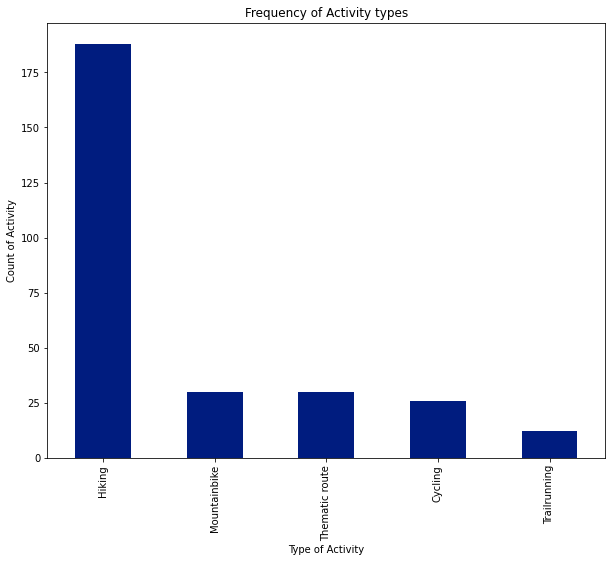

In [49]:
ax = analysis['sport'].value_counts().plot(kind='bar')
plt.title('Frequency of Activity types')
plt.xlabel('Type of Activity')
plt.ylabel('Count of Activity');

How does the picture look like by level of difficulty?

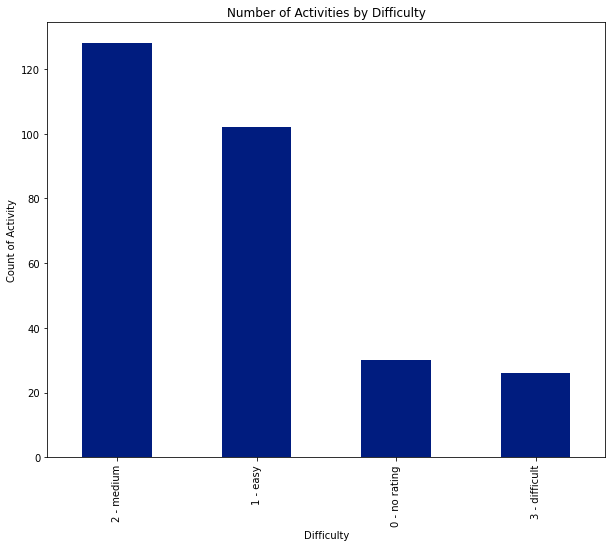

In [50]:
analysis['difficulty'].value_counts().plot(kind='bar')
plt.title('Number of Activities by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count of Activity');

### 3.4 Scatter Plot Visualization

The scatter plot paints an interesting picture of the trail data. First, the cycling trails are both the longest and the ones with most height difference out of the bunch. And second, it looks like all of the hiking trails fall between 2 and 20km (except for one). Perhaps this is because long distance hiking trails are considered to be "Pilgrimages"?

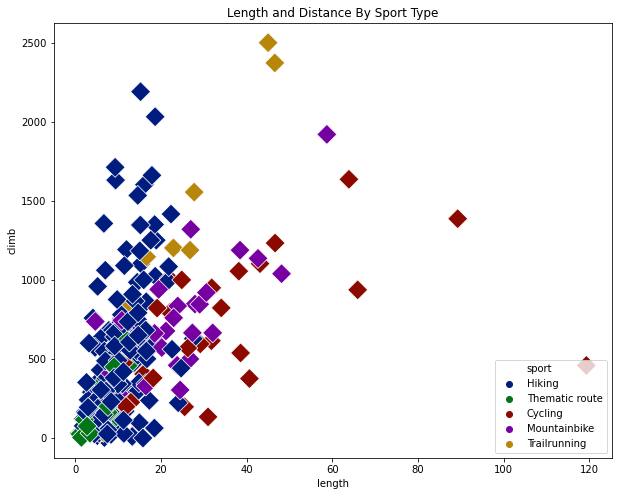

In [51]:
sns.scatterplot(    
    data=analysis,
    x="length", y="climb", hue='sport', 
    marker = "D", s=200, # set marker type and size
).set_title('Length and Distance By Sport Type')
plt.legend(loc='lower right'); # change default position of legend

In [52]:
# mean length for difficulty:
activities_df_br.groupby('difficulty').mean()

,ID,length,climb,min,max,technique,fitness
difficulty,,,,,,,
0 - no rating,452267.000000,12.640333,408.033333,841.966667,1237.500000,0.000000,0.000000
1 - easy,397930.828829,9.560450,251.378378,985.477477,1219.729730,1.369369,1.756757
2 - medium,432732.914286,15.402071,620.192857,1062.850000,1624.357143,2.464286,3.292857
3 - difficult,427644.054054,51.218108,2187.243243,835.324324,1879.864865,3.783784,5.351351


Now let's explore the data using only hiking trail data.

# 4 Analysis: Hiking Trails 

The primary interest of this analysis is hiking trail data. The following analysis will compare only hiking trails and drop the rest of the sport types.

In [53]:
hiking = activities_df_br[activities_df_br.sport == "Hiking"]
hiking.shape

(188, 11)

### 4.1 Scatter plot: Length and Distance of each Activity By Difficulty

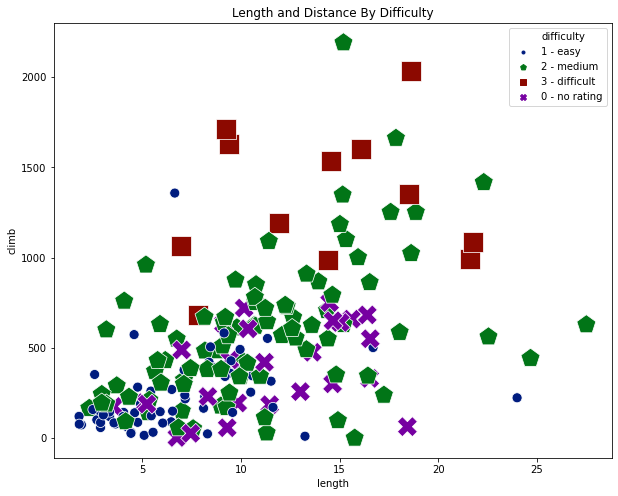

In [54]:
markers1 = {"1 - easy": ".", "2 - medium": "p",
           "3 - difficult":"s", "0 - no rating":"X"} #set the markers individually
sns.scatterplot(    
    data=hiking,
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], # rearrange order of the legend
    style='difficulty', markers = markers1, # set markers
    s = 400 # size of markers
).set_title('Length and Distance By Difficulty');

Seems we have one "outlier" which is more than 200km long. Let's remove it to get a better view on the majority of the trails.

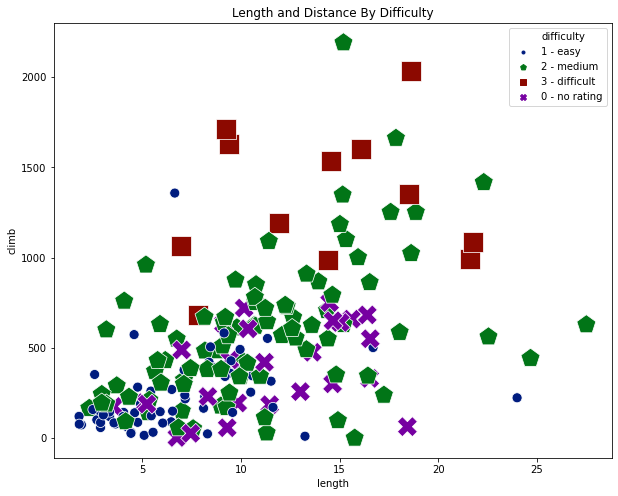

In [55]:
sns.scatterplot(    
    data=hiking[hiking.length < 200],
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], # rearrange order of the legend
    style='difficulty', markers = markers1, # set markers
    s = 400, # size of markers
).set_title('Length and Distance By Difficulty');

The easier trails seem to be shorter in length and with lower elevation gain. Let's see if there is a correlation.

### 4.2 Line Plot: Comparison of average Trail Length vs. Fitness Score

The following dataframe uses the fitness scores and compares them to the length of each trail. How correlated is the trail length to the fitness score? A new columns is added for average length. 

In [56]:
# calculating the count by Fitness level and the average length 
fitness_length_check = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()
fitness_length_check

,fitness,count,average_length
0,0,28,11.155357
1,1,24,5.527083
2,2,41,8.039024
3,3,51,10.359412
4,4,30,12.293333
5,5,11,12.962727
6,6,3,16.493333


The routes with no fitness rating seems quite long. Probably related to the outlier previously identified.
For further analysis let's remove the trails without any difficulty rating and check if there is a visual clue.

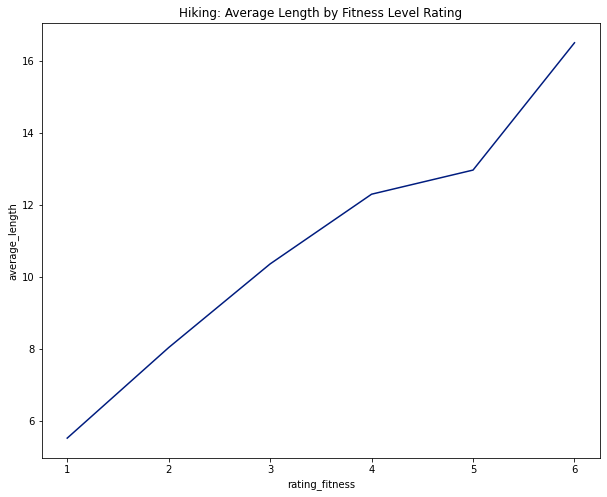

In [57]:
fitness_length = fitness_length_check[fitness_length_check['fitness'] != 0]
plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')
#sns.linewidth = 6
#check linestyle
plt.show()

There seems to be a relationship indeed between fitness score and length of the hike but let's have a closer look.

### 4.3 Boxplots: Difficulty vs. Elevation Gain and Length

The following boxplots show how the trail data is distributed by difficulty catagory compared to both elevation gain and length. It's pretty clear that the relationship between elevation gain and difficulty is more meaningful than the relationship between distance and difficulty. My legs agree! 

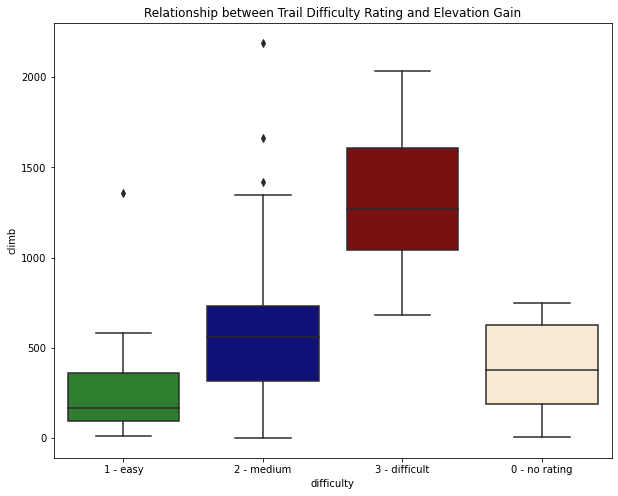

In [58]:
my_pal = {"1 - easy": "forestgreen", "2 - medium": "darkblue", "3 - difficult":"darkred", 
          "0 - no rating":"blanchedalmond"}
ax = sns.boxplot(x="difficulty", y="climb", data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Elevation Gain')\

# https://matplotlib.org/2.0.2/examples/color/named_colors.html

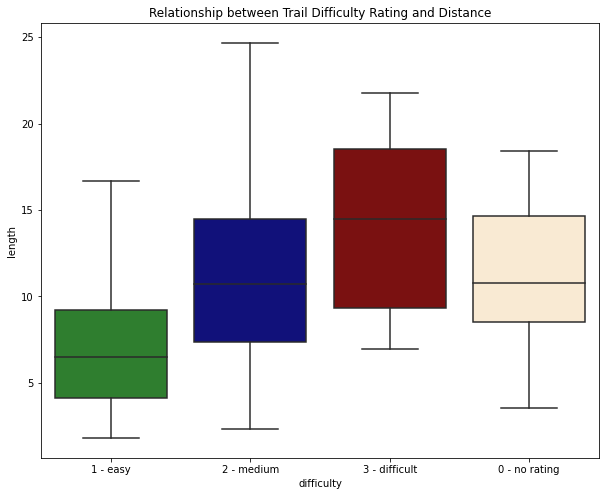

In [59]:
ax = sns.boxplot(x="difficulty", y="length",showfliers = False, data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Distance')

### 3.6 Correlation Matrix
Let's see what the mathematical correlations are between the four parameters: climb, length, fitness score, technique score. For that, trails without any rating will be excluded.

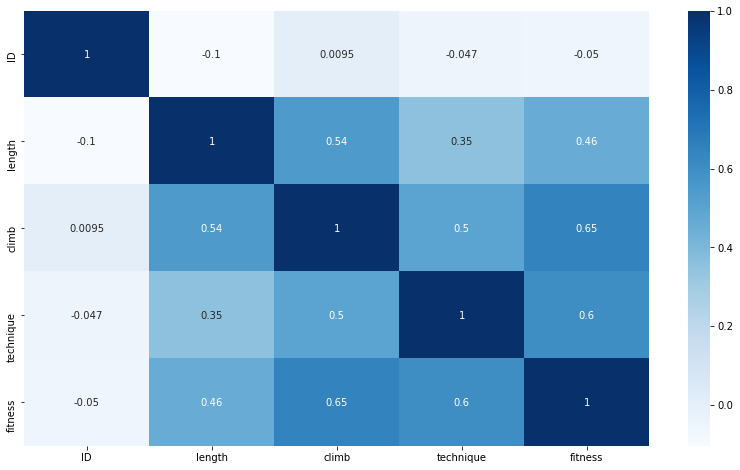

In [60]:
# remove numerical columns that are not needed and remove rows with no rating 
corr_matrix_df = hiking.drop(columns = ['min','max']).copy()
corr_matrix_df = corr_matrix_df[corr_matrix_df['difficulty'] != '0 - no rating']
# create a correlation matrix
corr_matrix = corr_matrix_df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues');

In [61]:
corr_matrix_df.head()

,ID,title,difficulty,sport,length,time,climb,technique,fitness
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,3,3
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,2,2
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,1,0
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,2,2
5,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,2,2


'Fitness' and 'Technique' have the highest correlation among all measures.
What about the correlation with the 'Difficulty Level'?
We therefore convert the 'easy', 'medium', 'difficult' in numeric values and build a correlation matrix.

In [62]:
# add numerical column indicating the difficulty level
corr_matrix_df['difficulty_level'] = corr_matrix_df['difficulty']
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '1 - easy', ['difficulty_level']] = 1
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '2 - medium', ['difficulty_level']] = 2
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '3 - difficult', ['difficulty_level']] = 3

# the column 'difficulty_level' will return object type which we need to convert to integers.
corr_matrix_df['difficulty_level']= corr_matrix_df['difficulty_level'].astype(str).astype(int)
#or corr_matrix_df2 = pd.to_numeric(corr_matrix_df['difficulty_level']).astype(int)
corr_matrix_df2 = corr_matrix_df.copy()
corr_matrix_df2

,ID,title,difficulty,sport,length,time,climb,technique,fitness,difficulty_level
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,3,3,2
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,2,2,1
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,1,0,1
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,2,2,1
5,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,2,2,1
...,...,...,...,...,...,...,...,...,...,...
306,799947,Anspruchsvolle Gipfeltour,3 - difficult,Hiking,18.61,05:30,2032,6,6,3
307,62404,Five star walk,2 - medium,Hiking,15.77,08:00,0,2,4,2
308,456685,Rundweg Hüslimad,2 - medium,Hiking,3.18,01:09,189,2,3,2
311,190774,dw Schynige Platte,2 - medium,Hiking,5.95,02:07,305,3,1,2


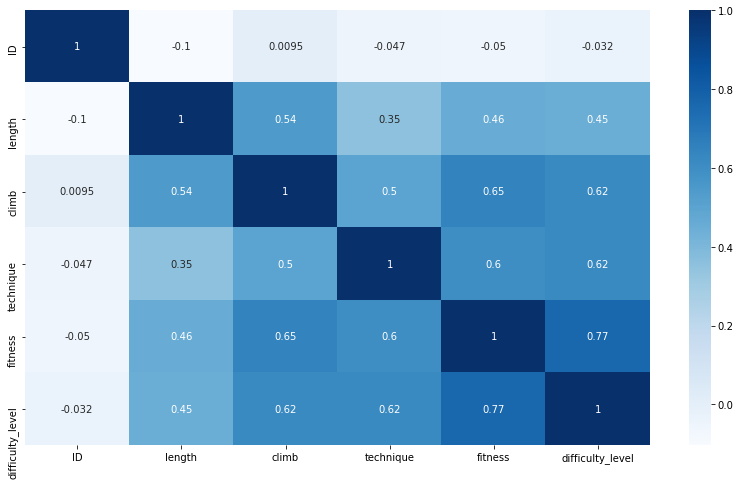

In [63]:
corr_matrix_level = corr_matrix_df2.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix_level, annot = True, cmap = 'Blues');

As we can see, the highest correlation is between the fitness level and the difficulty level, followed by the technique and the difficulty level. This was not visible in the box plot graphs above.

# 5 Download Trail GPS Data

The next part of this notebook deals with parsing HTML tags again, however this time around we will be gathering the GPS data needed to create the snowfall alert. The GPS data for each trail is actually a list of GPS points that comprise the length of the trail, from start to summit. However, we will only be using the first GPS point in our algorithm, which is the trail-head. 

The Bergfex website embedds their GPS data into downloadable files, which are meant to be uploaded to a GPS device for navigation purposes. As such, the following code will automatically download each GPS file into a folder. Importantly, a sleep timer is added to replicate how a human may download these files, if the sleep timer is not added, the website will become suspicious and prevent us from downloading more files. 

The type of GPS file that is being downloaded is a "GPX" or "GPS Exchange Format" file, which is a special type of XML file that can be used to describe waypoints. 

Finally, we crosscheck with Google Earth Web App, that our downloaded GPS data is exactly what we want.

### 5.1 Download Batches of GPX Files

This loop uses the hike id's to navigate to each of the hike's pages. It then downloads the GPS file to the folder "gpx_files" and saves it as a filename "Unique hike id.gpx". To prevent being blocked from the page, we download the dat in small batches for all 400 activities.

In [64]:
# create a small subset of data for testing
"""test_id = corr_matrix_df.iloc[20:22,0]
for hike_id in test_id: 
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(hike_id)};fileType=kml"
    print(url_id)
    r = requests.get(url_id, allow_redirects=True)          # Send the request
    time.sleep(5)                                           # Include a timer to prevent blocking
    write_link = ('../gpx_files/'+ str(hike_id) + ".gpx")   # Create gpx file
    with open(write_link, 'wb') as f:
        f.write(r.content)                                  # Write data for each ID in each file"""

'test_id = corr_matrix_df.iloc[20:22,0]\nfor hike_id in test_id: \n    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(hike_id)};fileType=kml"\n    print(url_id)\n    r = requests.get(url_id, allow_redirects=True)          # Send the request\n    time.sleep(5)                                           # Include a timer to prevent blocking\n    write_link = (\'../gpx_files/\'+ str(hike_id) + ".gpx")   # Create gpx file\n    with open(write_link, \'wb\') as f:\n        f.write(r.content)                                  # Write data for each ID in each file'

Let's look at the content of one download. There are lots of data points of which the key data needs to be filtered out.

In [65]:
"""r.content"""

'r.content'

###  5.2 Extract Coordinates from GPX files

Now that the GPX files have been downloaded to a local file, we can loop through them and extract the important information, which is the latitude and the longitude of the trail start.

In [66]:
"""list_of_trails_list = []
list_of_files = glob.glob('*gpx')                     # Create a list for each trail_id
for hike_id in test_id: 
    trail_gps_list = []
    gpx = gpxpy.parse(open('../gpx_files/'+str(hike_id)+'.gpx', 'r')) # Read content for each trail_id
    trail_gps_list.append(hike_id)
    for track in gpx.tracks: 
        trail_name = track.name                 # Track name
        trail_gps_list.append(trail_name)
        for segment in track.segments: 
            for point in segment.points: 
              lat = point.latitude              # Latitude
              trail_gps_list.append(lat)
              lon = point.longitude             # Longitude
              trail_gps_list.append(lon) 
              break
        list_of_trails_list.append(trail_gps_list)

print(list_of_trails_list)"""

"list_of_trails_list = []\nlist_of_files = glob.glob('*gpx')                     # Create a list for each trail_id\nfor hike_id in test_id: \n    trail_gps_list = []\n    gpx = gpxpy.parse(open('../gpx_files/'+str(hike_id)+'.gpx', 'r')) # Read content for each trail_id\n    trail_gps_list.append(hike_id)\n    for track in gpx.tracks: \n        trail_name = track.name                 # Track name\n        trail_gps_list.append(trail_name)\n        for segment in track.segments: \n            for point in segment.points: \n              lat = point.latitude              # Latitude\n              trail_gps_list.append(lat)\n              lon = point.longitude             # Longitude\n              trail_gps_list.append(lon) \n              break\n        list_of_trails_list.append(trail_gps_list)\n\nprint(list_of_trails_list)"

### 5.3  Create a Dataframe and save as CSV

Let's take a look at our data now that it has been extracted. It looks like everything is working as intended. Each trail has a unique ID and latitude and longitude. This data can now be saved to a CSV file which will be used for the snow alert in the next notebook. 

In [67]:
"""trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
trail_coords_df.to_csv('../data/trail_coords_df.csv', index=False) # save to CSV
coords_df = pd.read_csv('../data/trail_coords_df.csv')
coords_df"""

"trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF\ntrail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns\ntrail_coords_df.to_csv('../data/trail_coords_df.csv', index=False) # save to CSV\ncoords_df = pd.read_csv('../data/trail_coords_df.csv')\ncoords_df"

### 5.4 Check GPS example

Let's test one ID (131699) with its coordinates (lat = 46.508190, lon = 7.358150) in Google Earth web app. It correctly displays the location. 

Bergfex GPS data:
- https://www.bergfex.com/downloads/gps/?type=&id=131699&fileType=kml

Google Earth web app:
- https://earth.google.com/web/search/46%2e508190+7%2e358150/@46.50819,7.35815,2006.43177272a,699.98943356d,35y,0h,45t,0r/data=ClYaLBImGb4Ts14MQUdAIeU_pN--bh1AKhI0Ni41MDgxOTAgNy4zNTgxNTAYAiABIiYKJAlWqScNN6A1QBFWqScNN6A1wBkg4Hxc5e7VPyFlaK6dDdtZwA

In [68]:
"""example = coords_df[coords_df['trail_id'] == 131699]
example"""

"example = coords_df[coords_df['trail_id'] == 131699]\nexample"

<IPython.core.display.Javascript object>


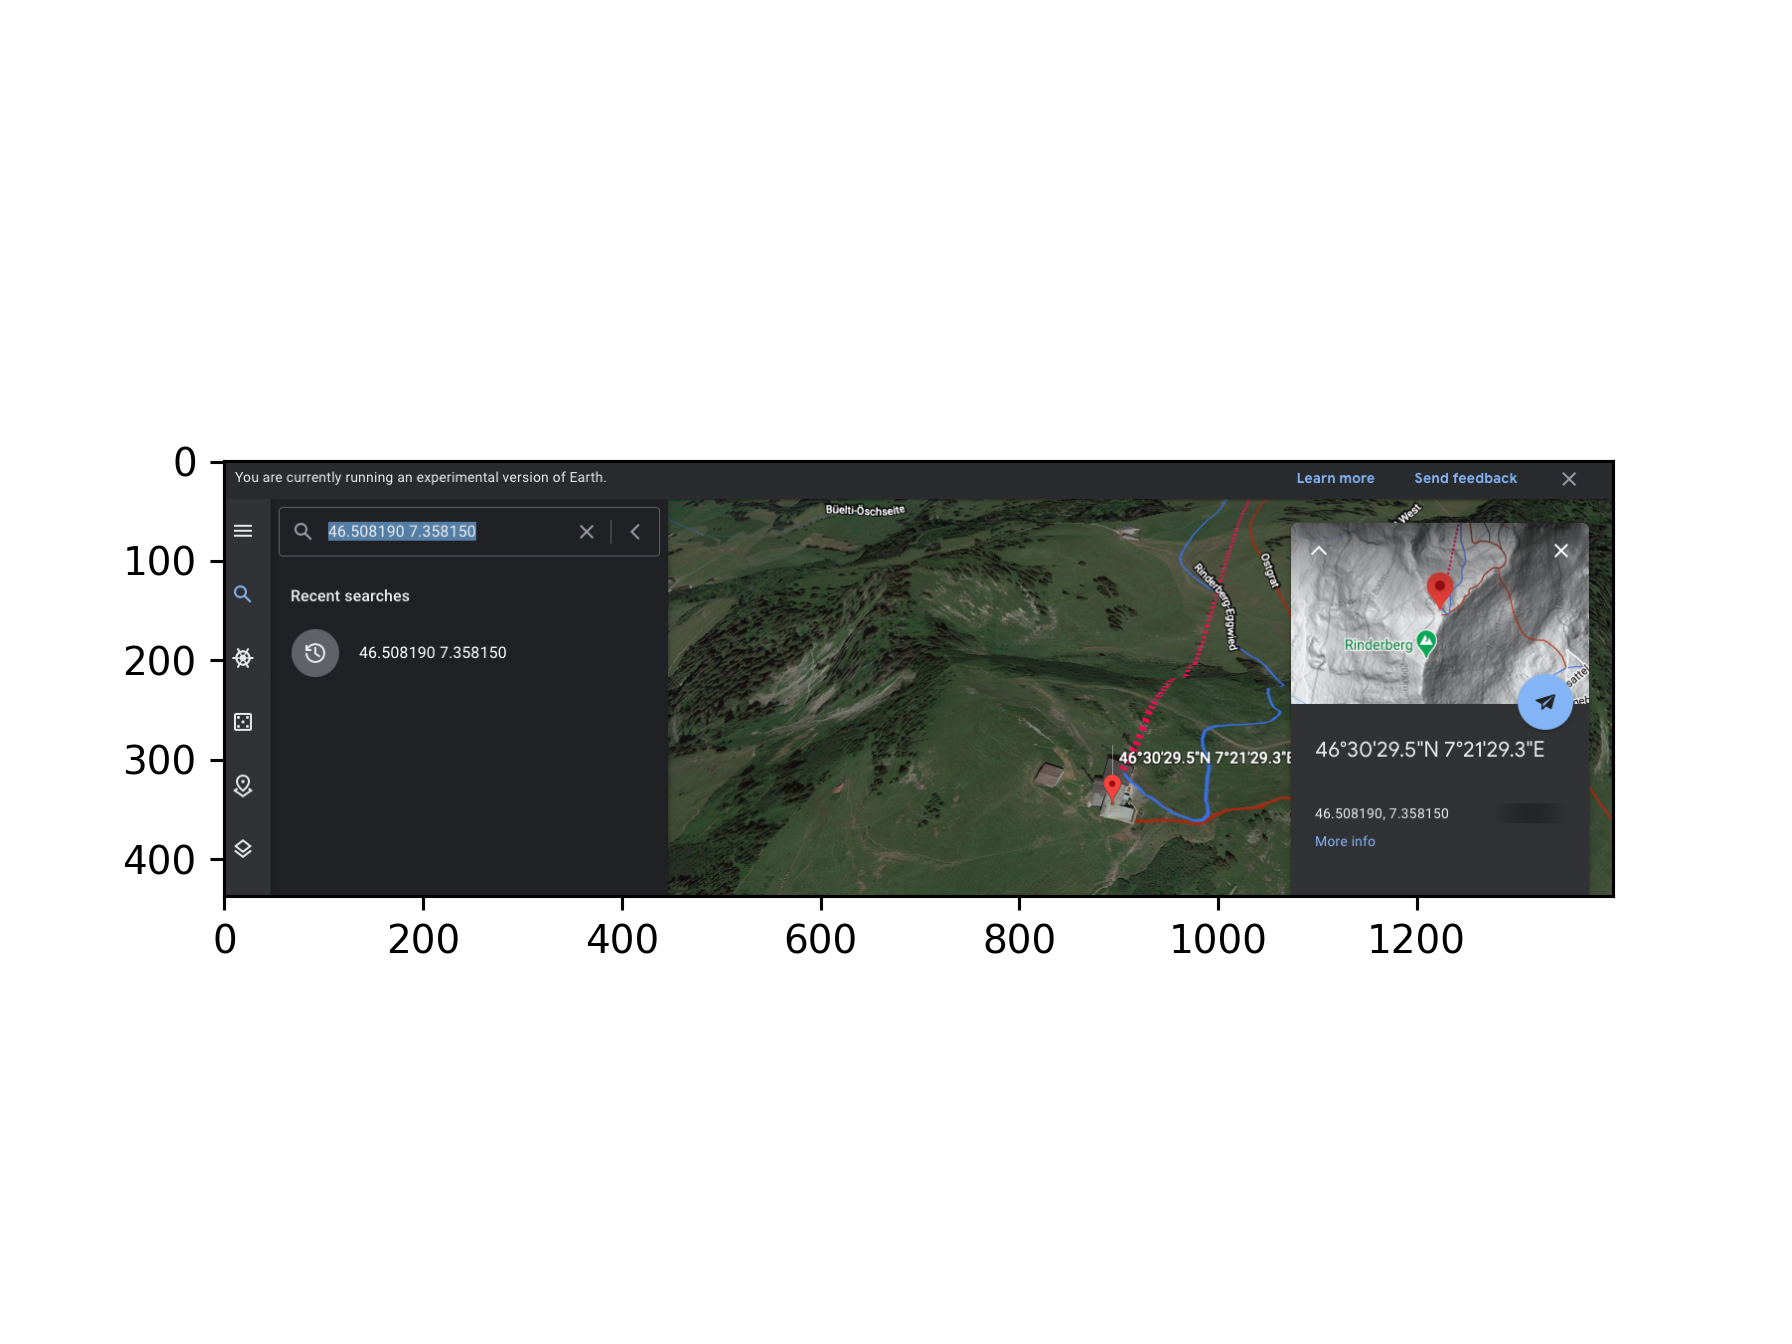

In [69]:
# needed to increase the display size of the png
%matplotlib notebook 
img = mpimg.imread('../GoogleEarth.png')
plt.rcParams['figure.dpi'] = 140
imgplot = plt.imshow(img)

### 5.5 Functions for GPS data

Now that we confirmed the GPS data, let's combine the code in functions. By adding tranches and a timer for their download, we make sure we will not be blocked by the website.

In [70]:
def build_tranches(region, tranch_len, save_as_csv = True):
    
    for_tranches_df = pd.read_csv(f"../data/activities_{region}.csv") # import csv file for corr. region
    
    n_tranches = math.ceil(len(for_tranches_df.iloc[:,0])/ tranch_len) # calculate # of tranches
    
    tranch_df = pd.DataFrame()
    start_t = 0
    end_t = tranch_len
    for i in range(n_tranches): # subset all IDs into different tranches and save in seperate columns of DF
        tranch_df[i] = for_tranches_df.iloc[start_t:end_t,0].reset_index(drop=True)
        start_t = start_t + tranch_len
        end_t = start_t + tranch_len
    tranch_df = tranch_df.fillna(0)
    tranch_df = tranch_df.astype(int).reset_index()
    
    if save_as_csv == True:                                    # Option to save to csv
        tranch_df.to_csv(f'../data/tranches_df_{region}.csv', index=False)
        
    return tranch_df

Build tranches for each region.

In [71]:
regions = ['aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich']
for reg in regions:
    build_tranches(reg, 70, save_as_csv = True)

Create a function that gets the GPX data for each regions based on the predefined tranches.

In [72]:
def get_gpx_data_new(region, save_as_csv = True):
    
    start_time = time.time()
    
    for_gpx_df = pd.read_csv(f"../data/tranches_df_{region}.csv") # import csv file for corr. region
    cols = for_gpx_df.columns.tolist() # define column names that need to be looped through
    cols = cols[2:] # take out index column
    
    list_of_trails_list = []
    
    for col in cols:
        # download the gpx files for each trail_id
        ids_df = for_gpx_df[col]
        ids_df = ids_df.loc[(ids_df != 0)] # filter out non-valid IDs
        for ids in ids_df: 
            url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
            r = requests.get(url_id, allow_redirects=True)    # Send the request
            write_link = ('../gpx_files/'+ str(ids) + ".gpx") # Create gpx file
            with open(write_link, 'wb') as f:
                f.write(r.content)                            # Write data for each ID in each file

            # extract the trail_id, name of the hike, lat, lon from GPX files
            trail_gps_list = []
            gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
            trail_gps_list.append(ids)
            for track in gpx.tracks: 
                trail_name = track.name                 # Track name
                trail_gps_list.append(trail_name)
                for segment in track.segments: 
                    for point in segment.points: 
                      lat = point.latitude              # Latitude
                      trail_gps_list.append(lat)
                      lon = point.longitude             # Longitude
                      trail_gps_list.append(lon) 
                      break
                list_of_trails_list.append(trail_gps_list)
        #col2 = str(col + 1)
        #print(f'Tranch #{col2} is done.')
        time.sleep(1500) 
    
    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_{region}_complete.csv', index=False)
    print("-- {0} seconds -- for {1} tranches".format(time.time() - start_time, len(cols))) # Record time needed
    
    return trail_coords_df

In [86]:
def get_gpx_data_remaining(df_remaining, tranch_len, save_as_csv = True):
    
    start_time = time.time()
    
    n_tranches = math.ceil(len(df_remaining.iloc[:,0])/ tranch_len) # calculate # of tranches
    
    tranch_df = pd.DataFrame()
    start_t = 0
    end_t = tranch_len
    for i in range(n_tranches): # subset all IDs into different tranches and save in seperate columns of DF
        tranch_df[i] = df_remaining.iloc[start_t:end_t,1].reset_index(drop=True)
        start_t = start_t + tranch_len
        end_t = start_t + tranch_len
    tranch_df = tranch_df.fillna(0)
    tranch_df = tranch_df.astype(int).reset_index()
    
    if save_as_csv == True:                                    # Option to save to csv
        tranch_df.to_csv(f'../data/tranches_df_remaining.csv', index=False)
        
    for_gpx_df =  tranch_df # import csv file for corr. region
    cols = for_gpx_df.columns.tolist() # define column names that need to be looped through
    cols = cols[1:] # take out index column
    
    list_of_trails_list = []
    
    for col in cols:
        # download the gpx files for each trail_id
        ids_df = for_gpx_df[col]
        ids_df = ids_df.loc[(ids_df != 0)] # filter out non-valid IDs
        for ids in ids_df: 
            url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
            r = requests.get(url_id, allow_redirects=True)    # Send the request
            write_link = ('../gpx_files/'+ str(ids) + ".gpx") # Create gpx file
            with open(write_link, 'wb') as f:
                f.write(r.content)                            # Write data for each ID in each file

            # extract the trail_id, name of the hike, lat, lon from GPX files
            trail_gps_list = []
            gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
            trail_gps_list.append(ids)
            for track in gpx.tracks: 
                trail_name = track.name                 # Track name
                trail_gps_list.append(trail_name)
                for segment in track.segments: 
                    for point in segment.points: 
                      lat = point.latitude              # Latitude
                      trail_gps_list.append(lat)
                      lon = point.longitude             # Longitude
                      trail_gps_list.append(lon) 
                      break
                list_of_trails_list.append(trail_gps_list)
        time.sleep(1300) 
    
    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_remaining_complete.csv', index=False)
    print("-- {0} seconds -- for {1} tranches".format(time.time() - start_time, len(cols))) # Record time needed
    
    return trail_coords_df

In [ ]:
#get_gpx_data_new('jura-drei-seen-land', save_as_csv = True)

In [75]:
def get_gpx_data(region, tranch_len):
    
    build_tranches(region, tranch_len, save_as_csv = True)
    trail_coords_df = get_gpx_data_new(region, save_as_csv = True)
 
    return trail_coords_df

Let's test it with our 'bern-region' download.

NOTE: 
- with 2 / 5 seconds / 10 tranch size blocked after 18 files / 2 tranches
- with 2 / 10 seconds / 8 tranch size blocked after 62 files / 6 tranches

In [76]:
def get_gpx_data_tranch(tranch_df, tranch_n, save_as_csv = True):
    
    start_time = time.time()
    
    list_of_trails_list = []
    
    # download the gpx files for each trail_id
    ids_df = tranch_df[tranch_n]
    ids_df = ids_df[ids_df[tranch_n] != 0]
    for ids in ids_df: 
        url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
        #print(url_id)
        r = requests.get(url_id, allow_redirects=True)    # Send the request
        time.sleep(2)                                     # Include a timer to prevent blocking
        write_link = ('../gpx_files/'+ str(ids) + ".gpx") # Create gpx file
        with open(write_link, 'wb') as f:
            f.write(r.content)                            # Write data for each ID in each file

    # extract the trail_id, name of the hike, lat, lon from GPX files
    list_of_files = glob.glob('*gpx')                     # Create a list for each trail_id
    for ids in ids_df: 
        trail_gps_list = []
        gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
        trail_gps_list.append(ids)
        for track in gpx.tracks: 
            trail_name = track.name                 # Track name
            trail_gps_list.append(trail_name)
            for segment in track.segments: 
                for point in segment.points: 
                  lat = point.latitude              # Latitude
                  trail_gps_list.append(lat)
                  lon = point.longitude             # Longitude
                  trail_gps_list.append(lon) 
                  break
            list_of_trails_list.append(trail_gps_list)

    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_{tranch_n}_all.csv', index=False)
    print("-- {0} seconds -- for tranch #{1}".format(time.time() - start_time, tranch_n)) # Record time needed
    return trail_coords_df

In [77]:
def gather_in_df(ids_df, save_as_csv = True):
    start_time = time.time()
    list_of_trails_list = []
    for ids in ids_df: 
        trail_gps_list = []
        gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
        trail_gps_list.append(ids)
        for track in gpx.tracks: 
            trail_name = track.name                 # Track name
            trail_gps_list.append(trail_name)
            for segment in track.segments: 
                for point in segment.points: 
                  lat = point.latitude              # Latitude
                  trail_gps_list.append(lat)
                  lon = point.longitude             # Longitude
                  trail_gps_list.append(lon) 
                  break
            list_of_trails_list.append(trail_gps_list)

    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_all.csv', index=False)
    print("-- {0} seconds --".format(time.time() - start_time)) # Record time needed
    return trail_coords_df

In [78]:
def gather_in_act_df(activities_df, save_as_csv = True):
    start_time = time.time()
    list_of_trails_list = []
    for ids in activities_df['ID']: 
        try:
            gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
            trail_gps_list = []
            trail_gps_list.append(ids)
            for track in gpx.tracks: 
                trail_name = track.name                 # Track name
                trail_gps_list.append(trail_name)
                for segment in track.segments: 
                    for point in segment.points: 
                      lat = point.latitude              # Latitude
                      trail_gps_list.append(lat)
                      lon = point.longitude             # Longitude
                      trail_gps_list.append(lon) 
                      break
                list_of_trails_list.append(trail_gps_list)
        except:
            trail_gps_list = [0,0,0,0]
            list_of_trails_list.append(trail_gps_list)
            
    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_all_test.csv', index=False)
    print("-- {0} seconds --".format(time.time() - start_time)) # Record time needed
    return trail_coords_df

In [88]:
all_act_df = pd.read_csv(f"../data/activities_all.csv")
gpx_all = gather_in_act_df(all_act_df, save_as_csv = True)
all_act_gpx = all_act_df.merge(gpx_all, how="left", left_on = 'ID', right_on = "trail_id", )
all_act_gpx.to_csv(f"../data/activities_all_gpx.csv", index=False)
filt_rem = all_act_gpx[all_act_gpx['trail_id'].isnull()]
filt_rem

-- 15.53521990776062 seconds --


,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness,region,trail_id,name,lat,lon
737,301337,Panorama-Bergwanderung Grimmiwasser,2 - medium,Thematic route,11.46,04:00,674,1222,1843.0,3,4,berneroberland,NaN,NaN,NaN,NaN
751,859945,Lauenen – Walliser Wispile (1982 M.ü.M),2 - medium,Ski tour,4.54,02:05,743,1239,1982.0,3,3,berneroberland,NaN,NaN,NaN,NaN
752,1040660,Von Basel zum Mont Blanc Etappe 8: Sonceboz–Chasseral,3 - difficult,Hiking,15.94,05:15,1020,652,1607.0,1,5,berneroberland,NaN,NaN,NaN,NaN
753,48769,Durch Auenwälder zu einem imposanten Schloss,1 - easy,Hiking,10.43,02:30,110,482,694.0,2,2,berneroberland,NaN,NaN,NaN,NaN
754,709668,Jegertosse-Fisialp,2 - medium,Hiking,12.26,05:50,988,1170,2157.0,4,4,berneroberland,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,347324,9 km round to eschenberg,0 - no rating,Hiking,8.90,01:31,214,440,589.0,3,3,zuerich,NaN,NaN,NaN,NaN
3793,860559,Trails,2 - medium,Mountainbike,39.85,02:26,863,451,824.0,5,4,zuerich,NaN,NaN,NaN,NaN
3794,886876,2001004 Andelfingen Schloss 1-1 km + 41 m -16 m,1 - easy,Hiking,1.10,-,0,392,392.0,1,1,zuerich,NaN,NaN,NaN,NaN
3795,569711,Schaffhausen - Rheinfall - Jestetten (DE),2 - medium,Hiking,18.69,04:07,786,353,440.0,2,5,zuerich,NaN,NaN,NaN,NaN


In [80]:
current_gpx = pd.read_csv(f"../data/activities_all_gpx.csv")
current_gpx.shape

(3797, 16)

In [87]:
filt_ids = filt_rem.iloc[:276,0].reset_index()
get_gpx_data_remaining(filt_ids, tranch_len = 69, save_as_csv = True)

GPXXMLSyntaxException: Error parsing XML: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

In [ ]:
https://www.bergfex.com/downloads/gps/?type=&id=162906;fileType=kml

# CONTINUE IN NOTEBOOK II